<a href="https://colab.research.google.com/github/decomiteA/AcinoSet/blob/main/Trajectory_optimization_and_Mujoco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import mujoco and define the model

## Import functions for mujoco (from deepmind control)

In [2]:
#@title Installation of MuJoCo and "dm_control"
import distutils.util
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU colab runtime. '
      'Go to the Runtime menu and select Choose runtime type. ')
  
print('Installing dm_control...')  
!pip install -q dm_control>=1.0.3.post1

# Configure dm_control to use the EGL rendeirng backing (requires GPU)
%env MUJOCO_GL=egl

print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole','swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during the installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selectin "Choose runtime type"')
else:
  del pixels, suite
!echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")


Installing dm_control...
env: MUJOCO_GL=egl
Checking that the dm_control installation succeeded...
Installed dm_control 1.0.3.post1


In [4]:
#@title All "dm_control" imports required for this code 

# the basic mujoco wrapper
from dm_control import mujoco

# access to enums and mujoco library functions
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# pymjcf
from dm_control import mjcf 

# composer high level imports 
from dm_control import composer 
from dm_control.composer.observation import observable 
from dm_control.composer import variation

# Imports for composer use
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises 
from dm_control.locomotion.arenas import floors

# control suite 
from dm_control import suite 

# run through corridor import 
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridors_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# soccer
from dm_control.locomotion import soccer 

#manipulation
from dm_control import manipulation


In [5]:
#@title Other imports and helper functions 

# General
import copy
import os 
import itertools 
from IPython.display import clear_output
import numpy as np

# Graphics related 
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt 
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries 

# Use svg backend for figure rendering 
%config InlineBackend.figure_format = 'svg'

#Font sizes 
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size = SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  display_video = lambda *args, **kwargs: None
else: 
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


# Model definition 

We define the model as a bipedal walker actuated by two legs composed of a 

In [6]:
BODY_RADIUS = .1
BODY_SIZE = (BODY_RADIUS, BODY_RADIUS, BODY_RADIUS)
random_state = np.random.RandomState(42)

class BiactuatedLeg(object):
  """A 2-DOF leg with position actuator"""
  def __init__(self, length, rgba):
    self.model = mjcf.RootElement()

    # Default parameters 
    self.model.default.joint.damping = 2 
    self.model.default.joint.type = 'hinge'
    self.model.default.geom.type = 'capsule'
    self.model.default.geom.rgba = rgba

    # Thigh
    self.thigh = self.model.worldbody.add('body')
    self.hip = self.thigh.add('joint',axis=[0,0,1])
    self.thigh.add('geom', fromto=[0,0,0,0,0,-length],size=[length/4])

    # Hip
    self.shin = self.thigh.add('body', pos=[0, 0, -length])
    self.knee = self.shin.add('joint', axis=[0, 1, 0])
    self.shin.add('geom',fromto=[0,0,0,0,0,-length],size=[length/5])

    # Position actuators
    self.model.actuator.add('position', joint=self.hip, kp=10)
    self.model.actuator.add('position', joint=self.knee, kp=10)

def make_humans():
  """Creates a humanoid with "num legs" legs"""
  rgba = random_state.uniform([1, 0, 0, 1], [1, 0, 0, 1])
  model = mjcf.RootElement()
  model.compiler.angle ='radian'

  model.worldbody.add('geom',name='torso',type='ellipsoid',size=BODY_SIZE, rgba=rgba)
  thetas = [-np.pi/2, np.pi/2]
  for ii in range(2):
    theta = thetas[ii]
    hip_pos = BODY_RADIUS * np.array([np.cos(theta), np.sin(theta),0])
    hip_site = model.worldbody.add('site', pos=hip_pos, euler=[0,0,0])
    leg = BiactuatedLeg(length=BODY_RADIUS, rgba=rgba)
    hip_site.attach(leg.model)

  return model

class MonkeyArm(object):
  """ A 2-DOF monkey arm attached on the ceiling"""
  def __init__(self,length,rgba):
    self.model = mjcf.RootElement()

    # Default parameters
    self.model.default.joint.damping = 2
    self.model.default.joint.type = 'hinge'
    self.model.default.geom.type = 'capsule'
    self.model.default.geom.rgba = rgba

    # Upper arm
    self.upperArm = self.model.worldbody.add('body')
    self.shoulder = self.upperArm.add('joint',axis=[0,1,0],name='shoulder')
    self.upperArm.add('geom',fromto=[0,0,0,0.1,0,-length],size=[length/8])

    # Forarm
    self.forarm = self.upperArm.add('body',pos=[0,0,-length])
    self.elbow = self.forarm.add('joint',axis=[0,1,0],name='elbow')
    self.forarm.add('geom',fromto=[0,0,0,0.1,0,-length],size=[length/8])

    # Position actuators 
    self.model.actuator.add('position', joint=self.shoulder, kp=10)
    self.model.actuator.add('position',joint=self.elbow, kp=10)

def make_monkey():
  """Create a monkey hanging from a given point"""
  rgba = random_state.uniform([1,0,0,1],[1,0,0,1])
  model = mjcf.RootElement()
  model.compiler.angle ='radian'

  model.worldbody.add('geom',name='torso',type='ellipsoid',size=(0.01,0.01,0.01), rgba=rgba)
  shoulder_pos = BODY_RADIUS * np.array([0, 0,0])
  shoulder_site = model.worldbody.add('site', pos=shoulder_pos, euler=[0,0,0])
  arm = MonkeyArm(length=0.2, rgba=rgba)
  shoulder_site.attach(arm.model)

  return model

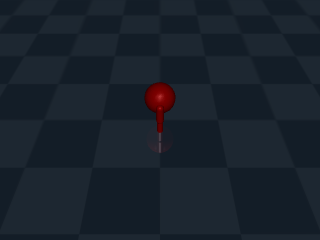

In [7]:
#Visualize the humanoid 

arena = mjcf.RootElement()
chequered = arena.asset.add('texture', type='2d', builtin='checker',width=300,
                            height = 300, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
grid = arena.asset.add('material', name='grid', texture=chequered,
                       texrepeat=[5, 5], reflectance = .2)
arena.worldbody.add('geom', type='plane', size=[2, 2, .1], material = grid)

humanoid = make_humans()
height = .2

spawn_pos = (0, 0, height)
spawn_site = arena.worldbody.add('site', pos=spawn_pos)
spawn_site.attach(humanoid).add('freejoint')

physics = mjcf.Physics.from_mjcf_model(arena)
PIL.Image.fromarray(physics.render())

In [8]:
# Investigating the actuation

duration = 10
pos_x = []
pos_y = []
pos_z = []
torso = []
actuator = []
torso.append(humanoid.find('geom','torso'))
actuator.extend(humanoid.find_all('actuator'))

physics.reset()
while physics.data.time < duration:
  physics.bind(actuator).ctrl = 1
  physics.step()

  pos_x.append(physics.bind(torso).xpos[:,0].copy())
  pos_y.append(physics.bind(torso).xpos[:,1].copy())
  pos_z.append(physics.bind(torso).xpos[:,2].copy())

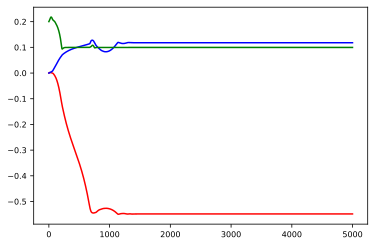

In [9]:
plt.plot(pos_x,color='red')
plt.plot(pos_y,color='blue')
plt.plot(pos_z,color='green')

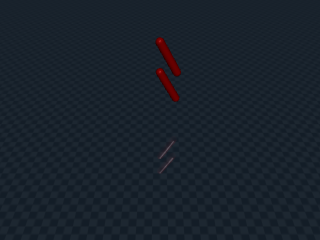

In [11]:
arena2 = mjcf.RootElement()
chequered = arena2.asset.add('texture', type='2d', builtin='checker',width=1000,
                            height = 1000, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
grid = arena2.asset.add('material', name='grid', texture=chequered,
                       texrepeat=[50, 50], reflectance = .2)
arena2.worldbody.add('geom', type='plane', size=[2, 2, .1], material = grid)

monkey = make_monkey()
height = .6

spawn_pos = (0, 0, height)
spawn_site = arena2.worldbody.add('site', pos=spawn_pos)
spawn_site.attach(monkey).add('joint',type='hinge',axis=[0,1,0])

physics = mjcf.Physics.from_mjcf_model(arena2)
PIL.Image.fromarray(physics.render(camera_id=-1))

In [12]:
#@title Video of the movement 
duration = 50
framerate = 30
video = []
pos_x = []
pos_y = []
torsos = []
actuators = []

torsos.append(monkey.find('geom','torso'))
actuators.extend(monkey.find_all('actuator'))

freq = 5
phase = 2 * np.pi * random_state.rand(len(actuators))
amp = 0

physics.reset()
physics.model.opt.timestep=0.0005
physics.model.opt.integrator=0
joint_angles = physics.data.qpos
joint_vel = physics.data.qvel
while physics.data.time < duration:
  physics.bind(actuators).ctrl = amp * physics.data.time
  physics.step()

  pos_x.append(physics.bind(torsos).xpos[:,0].copy())
  pos_y.append(physics.bind(torsos).xpos[:,1].copy())
  joint_angles = np.vstack((joint_angles,physics.data.qpos))
  joint_vel = np.vstack((joint_vel,physics.data.qvel))


  if len(video) < physics.data.time * framerate:
    pixels = physics.render()
    video.append(pixels.copy())

display_video(video, framerate)

In [ ]:
print(physics.model.opt.integrator)

(2,)

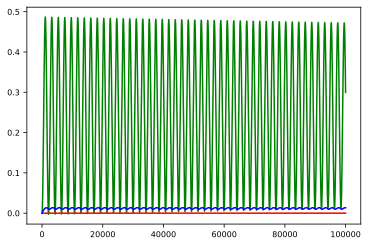

In [13]:

plt.plot(joint_angles[:,0],color='g')
plt.plot(joint_angles[:,1],color='r')
plt.plot(joint_angles[:,2],color='b')

physics.bind(actuators).ctrl.shape

# Adding trajectory optimization with the mujoco model 

TODO 

- Finding how to send motor commands to the system 
- Finding how to collect information from the system
- Eventually accelerating the resolution to make it work smoothly 

In [14]:
import scipy
from scipy import optimize
from scipy import integrate 

/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np

In [78]:
#Define the functions that allows to create the monkey with different initial states - Requird for the minimization process

class CustomMonkeyArm(object):
  """ A 2-DOF monkey arm attached on the ceiling - with the possibility to adjust he initial state"""
  def __init__(self,length,angle1,angle2,rgba):
    self.model = mjcf.RootElement()

    # Default parameters
    self.model.default.joint.damping = 0
    self.model.default.joint.type = 'hinge'
    self.model.default.geom.type = 'capsule'
    self.model.default.geom.rgba = rgba

    # Upper arm
    self.upperArm = self.model.worldbody.add('body')
    self.shoulder = self.upperArm.add('joint',axis=[0,1,0], ref=angle1, name='shoulder')
    self.upperArm.add('geom',fromto=[0,0,0,length*np.cos(angle1),0,length*np.sin(angle1)],size=[length/8],mass=50)

    # Forarm
    self.forarm = self.upperArm.add('body',pos=[length*np.cos(angle1),0,length*np.sin(angle1)])
    self.elbow = self.forarm.add('joint',axis=[0,1,0], ref=angle2 ,name='elbow')
    self.forarm.add('geom',fromto=[0,0,0,length*np.cos(angle1+angle2),0,length*np.sin(angle1+angle2)],size=[length/8],mass=16.5)
    # Position actuators 
    self.model.actuator.add('motor', joint=self.shoulder)
    self.model.actuator.add('motor',joint=self.elbow)

def make_custom_monkey(initial_state):
  """Create a customed monkey hanging from a given point"""
  global paraminput
  rgba = random_state.uniform([1,0,0,1],[1,0,0,1])
  model = mjcf.RootElement()
  model.compiler.angle ='radian'

  model.worldbody.add('geom',name='torso',type='ellipsoid',size=(0.01,0.01,0.01), rgba=rgba)
  shoulder_pos = BODY_RADIUS * np.array([0, 0,0])
  shoulder_site = model.worldbody.add('site', pos=shoulder_pos, euler=[0,0,0])
  arm = CustomMonkeyArm(paraminput["Larm"],initial_state[0],initial_state[1], rgba=rgba)
  shoulder_site.attach(arm.model)
  return model

def createArena(initial_state):
  """Creates the arena for the iterations"""
  arena = mjcf.RootElement()
  chequered = arena.asset.add('texture', type='2d', builtin='checker',width=1000,
                            height = 1000, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
  grid = arena.asset.add('material', name='grid', texture=chequered,
                       texrepeat=[50, 50], reflectance = .2)
  arena.worldbody.add('geom', type='plane', size=[2, 2, .1], material = grid)
  monkey = make_custom_monkey(initial_state)
  height = 2.5
  spawn_pos = (0, 0, height)
  spawn_site = arena.worldbody.add('site', pos=spawn_pos)
  spawn_site.attach(monkey).add('joint',type='hinge',axis=[0,1,0])
  return arena, monkey

In [72]:
def MujocoIntegration(motor_input, n_steps, outer_model=arena2, inner_model=monkey):
  """ This function computes the outcome of the mujoco integration"""
  global paraminput
  params = paraminput
  total_time = params["total_time"]
  actuators = []
  physics = mjcf.Physics.from_mjcf_model(outer_model)
  actuators.extend(inner_model.find_all('actuator'))
  time_interval = total_time / params["n_shoots"]
  numperinterval = n_steps
  # numperinterval = time_interval/(physics.timestep())
  bounds = np.linspace(0,total_time,params["n_shoots"]+1)
  physics.reset()
  physics.model.opt.timestep = time_interval/numperinterval
  physics.model.opt.integrator = 1
  #print(physics.model.opt.timestep)
  joint_angles = physics.data.qpos[1:]
  joint_vel = physics.data.qvel[1:]
  motor_inputs = motor_input[0,:]
  #print(motor_input)
  for countinterval in range(0, params["n_shoots"]-1):
    #print(countinterval)
    while physics.data.time < bounds[countinterval+1]:
      Tor1 = motor_input[countinterval,0] + (motor_input[countinterval+1,0] - motor_input[countinterval,0])/(time_interval) * (physics.data.time-bounds[countinterval]) 
      Tor2 = motor_input[countinterval,1] + (motor_input[countinterval+1,1] - motor_input[countinterval,1])/(time_interval) * (physics.data.time-bounds[countinterval])
      #print(Tor1)
      #print(Tor2)
      shoot_motor_inputs = np.hstack((Tor1,Tor2))
      physics.bind(actuators).ctrl = shoot_motor_inputs
      physics.step()
      joint_angles = np.vstack((joint_angles, physics.data.qpos[1:]))
      joint_vel = np.vstack((joint_vel, physics.data.qvel[1:]))
      #print(physics.data.qvel[1:])
      motor_inputs = np.vstack((motor_inputs, shoot_motor_inputs))
  outputs = np.hstack((joint_angles, joint_vel, motor_inputs))


  return outputs

def constraints_ineq1(pinput):
  """Defines the first inequality constraints for the brachiation problem"""
  global paraminput
  theta1_0 = pinput[0]
  theta2_0 = pinput[1]
  x_0 = paraminput["Larm"] * np.cos(theta1_0) + paraminput["Larm"] * np.cos(theta1_0 + theta2_0)
  return x_0

def constraints_ineq2(pinput):
  """Defines the second inequality constraints for the brachiation problem"""
  global paraminput
  aa1 = pinput[4:5+paraminput["n_shoots"]-1]
  aa2 = pinput[4+paraminput["n_shoots"]:5+2*paraminput["n_shoots"]-1]
  motor_input = np.hstack((np.expand_dims(aa1, axis=1), np.expand_dims(aa2, axis=1)))
  outer_model, inner_model = createArena(pinput[:2])
  output_matrix = MujocoIntegration(motor_input, 3, outer_model, inner_model)
  theta1_end = output_matrix[-1,0]
  theta2_end = output_matrix[-1,1]

  x_end = paraminput["Larm"] * np.cos(theta1_end) + paraminput["Larm"] * np.cos(theta1_end + theta2_end)
  return -x_end

def constraints_ineq3(pinput):
  """Defines the third inequality constraint for the brachiation problem"""
  global paraminput
  aa1 = pinput[4:5+paraminput["n_shoots"]-1]
  aa2 = pinput[4+paraminput["n_shoots"]:5+2*paraminput["n_shoots"]-1]
  motor_input = np.hstack((np.expand_dims(aa1, axis=1), np.expand_dims(aa2, axis=1)))
  outer_model, inner_model = createArena(pinput[:2])
  output_matrix = MujocoIntegration(motor_input, 3, outer_model, inner_model)
  theta1_store = output_matrix[:,0]
  return theta1_store

def constraints_eq1(pinput):
  """Defines the first equality constraint for the brachiation problem"""
  global paraminput
  theta1_0 = pinput[0]
  theta2_0 = pinput[1]
  y_0 = paraminput["Larm"] * np.sin(theta1_0) + paraminput["Larm"] * np.sin(theta1_0 + theta2_0)
  return y_0

def constraints_eq2(pinput):
  """Defines the second equality constraint for the brachiation problem"""
  global paraminput
  aa1 = pinput[4:5+paraminput["n_shoots"]-1]
  aa2 = pinput[4+paraminput["n_shoots"]:5+2*paraminput["n_shoots"]-1]
  motor_input = np.hstack((np.expand_dims(aa1, axis=1), np.expand_dims(aa2, axis=1)))
  outer_model, inner_model = createArena(pinput[:2])
  output_matrix = MujocoIntegration(motor_input, 3, outer_model, inner_model)
  theta1_end = output_matrix[-1,0]
  theta2_end = output_matrix[-1,1]
  y_end = paraminput["Larm"] * np.sin(theta1_end) + paraminput["Larm"] * np.sin(theta1_end + theta2_end)
  return y_end

def constraints_eq3(pinput):
  """Defines the third equality constraint for the brachiation problem"""
  global paraminput
  dtheta1_0 = pinput[2]
  return dtheta1_0

def constraints_eq4(pinput):
  """Defines the fourth equality constraint for the brachiation problem"""
  global paraminput
  dtheta2_0 = pinput[3]
  return dtheta2_0

def constraints_eq5(pinput):
  """Defines the fifth equality constraint for the brachiation problem"""
  global paraminput
  aa1 = pinput[4:5+paraminput["n_shoots"]-1]
  aa2 = pinput[4+paraminput["n_shoots"]:5+2*paraminput["n_shoots"]-1]
  motor_input = np.hstack((np.expand_dims(aa1, axis=1), np.expand_dims(aa2, axis=1)))
  outer_model, inner_model = createArena(pinput[:2])
  output_matrix = MujocoIntegration(motor_input, 3, outer_model, inner_model)
  dtheta1_end = output_matrix[-1,2]
  return dtheta1_end

def constraints_eq6(pinput):
  """Defines the sixth equality constraint for the brachiation problem"""
  global paraminput
  aa1 = pinput[4:5+paraminput["n_shoots"]-1]
  aa2 = pinput[4+paraminput["n_shoots"]:5+2*paraminput["n_shoots"]-1]
  motor_input = np.hstack((np.expand_dims(aa1, axis=1), np.expand_dims(aa2, axis=1)))
  outer_model, inner_model = createArena(pinput[:2])
  output_matrix = MujocoIntegration(motor_input, 3, outer_model, inner_model)
  dtheta2_end = output_matrix[-1,3]
  return dtheta2_end

def ConstraintsDefinition():
  """This functions defines the constraints of the optimization problem"""
  con1 = {'type':'ineq','fun':constraints_ineq1}
  con2 = {'type':'ineq','fun':constraints_ineq2}
  con3 = {'type':'ineq','fun':constraints_ineq3}
  con4 = {'type':'eq','fun':constraints_eq1}
  con5 = {'type':'eq','fun':constraints_eq2}
  con6 = {'type':'eq','fun':constraints_eq3}
  con7 = {'type':'eq','fun':constraints_eq4}
  con8 = {'type':'eq','fun':constraints_eq5}
  con9 = {'type':'eq','fun':constraints_eq6}
  constraints = [con1, con2, con3, con4, con5, con6, con7, con8, con9]
  return constraints

def ObjectiveFunction(pinput):
  """This function defines the objective function of the optimization problem"""
  global paraminput
  global var_fncount
  aa1 = pinput[4:5+paraminput["n_shoots"]-1]
  aa2 = pinput[4+paraminput["n_shoots"]:5+2*paraminput["n_shoots"]-1]
  motor_input = np.hstack((np.expand_dims(aa1, axis=1), np.expand_dims(aa2, axis=1)))
  outer_model, inner_model = createArena(pinput[:2])
  output_matrix = MujocoIntegration(motor_input, 10, outer_model, inner_model)
  total_cost = np.sum(np.square(output_matrix[:,-2])+np.square(output_matrix[:,-1]))
  return total_cost

In [77]:
#Testing the mujoco integration 
global paraminput
paraminput = dict.fromkeys(["n_shoots","Larm","total_time","Torqhandmax","Torqshoulmax"])
paraminput["n_shoots"] = 6
paraminput["Larm"] = 0.5
paraminput["total_time"] = 0.1
paraminput["Torqhandmax"] = 50
paraminput["Torqshoulmax"] = 50
global var_fncount
var_fncount = 0
#Define the constraints 
constraints = ConstraintsDefinition()
bounds_tuple = ((-2*np.pi, 2*np.pi), (-2*np.pi, 2*np.pi), (-3,3), (-3, 3))
for ii in range(paraminput["n_shoots"]):
  bounds_tuple = bounds_tuple + ((-paraminput["Torqhandmax"], paraminput["Torqhandmax"]), )
for ii in range(paraminput["n_shoots"]):
  bounds_tuple = bounds_tuple + ((-paraminput["Torqshoulmax"], paraminput["Torqshoulmax"]), )

theta1_0 = -2.3072
dtheta1_0 = 0
theta2_0 = -1.6271
dtheta2_0 = 0

pinput_0 = (theta1_0, theta2_0, dtheta1_0, dtheta2_0)
# Define the initial guess 
for ii in range(paraminput["n_shoots"]):
  pinput_0 = pinput_0 + (0, )
for ii in range(paraminput["n_shoots"]):
  pinput_0 = pinput_0 + (0, )
# Perform the optimization itself 
result = optimize.minimize(ObjectiveFunction, pinput_0, bounds=bounds_tuple, method='SLSQP', constraints=constraints, options={'maxiter':1000, 'ftol':1e-9, 'disp':True})

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 3478.2418102309666
            Iterations: 388
            Function evaluations: 8956
            Gradient evaluations: 384


In [79]:
print(result.nit)
print(result.x)

388
[ -2.591182    -1.10082107   0.           0.           7.19341176
  -0.28211484   4.97726056   3.06425046  -5.14548684 -10.74092028
   2.89187871  -9.7979825   -0.06882789  -5.78327083  -1.69730371
  19.37920158]


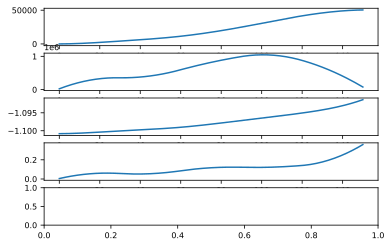

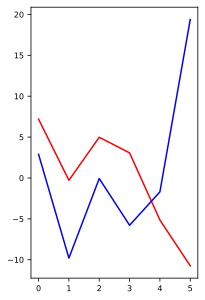

In [80]:
# Define here the postprocessing function 
def brachiation_postprocess(pinput,params):
  """Post process the result of the brachiation problem and represent the solution"""
  theta1_0 = pinput[0]
  theta2_0 = pinput[1]
  dtheta1_0= pinput[2]
  dtheta2_0= pinput[3]
  aa1 = pinput[4:5+paraminput["n_shoots"]-1]
  aa2 = pinput[4+paraminput["n_shoots"]:5+2*paraminput["n_shoots"]-1]
  motor_input = np.hstack((np.expand_dims(aa1, axis=1), np.expand_dims(aa2, axis=1)))
  outer_model, inner_model = createArena(pinput[:2])
  output_matrix = MujocoIntegration(motor_input, 30, outer_model, inner_model)
  theta1_store = output_matrix[:,0]
  dtheta1_store= output_matrix[:,2]
  theta2_store = output_matrix[:,1]
  dtheta2_store= output_matrix[:,3]
 #cost_store   = np.square(output_matrix[:,4],axis=0) + np.square(output_matrix[:,4],axis=0)

  fig, axs = plt.subplots(5,1)
  axs[0].plot(theta1_store[1:])
  axs[1].plot(dtheta1_store[1:])
  axs[2].plot(theta2_store[1:])
  axs[3].plot(dtheta2_store[1:])
  #axs[4].plot(cost_store[1:])
  plt.show()
brachiation_postprocess(result.x, paraminput)
pinput_test = (theta1_0, theta2_0, dtheta1_0, dtheta2_0)
# Define the initial guess 
for ii in range(paraminput["n_shoots"]):
  pinput_test = pinput_test + (10, )
for ii in range(paraminput["n_shoots"]):
  pinput_test = pinput_test + (-10, )
#brachiation_postprocess(pinput_test, paraminput)

plt.figure(figsize=(3,5))
plt.plot(result.x[4:10],color='r')
plt.plot(result.x[10: ],color='b')

In [ ]:
outer_model, inner_model = createArena(pinput_0[:2])
physics = mjcf.Physics.from_mjcf_model(outer_model)

#@title Video of the movement 
duration = 10
framerate = 30
video = []
pos_x = []
pos_y = []
torsos = []
actuators = []
actuators.append(inner_model.find_all('actuator'))
torsos.append(inner_model.find('geom','torso'))

total_time = paraminput["total_time"]
actuators = []
physics = mjcf.Physics.from_mjcf_model(outer_model)
actuators.extend(inner_model.find_all('actuator'))
time_interval = total_time / params["n_shoots"]
numperinterval = n_steps
bounds = np.linspace(0,total_time,params["n_shoots"]+1)
physics.reset()
joint_angles = physics.data.qpos
joint_vel = physics.data.qvel
for countinterval in range(0, paraminput["n_shoots"]-1):
  while physics.data.time < bounds[countinterval+1]:
    Tor1 = motor_input[countinterval,0] + (motor_input[countinterval+1,0] - motor_input[countinterval,0])/(time_interval) * (physics.data.time-bounds[countinterval]) 
    Tor2 = motor_input[countinterval,1] + (motor_input[countinterval+1,1] - motor_input[countinterval,1])/(time_interval) * (physics.data.time-bounds[countinterval])
    shoot_motor_inputs = np.hstack((Tor1,Tor2))
    physics.bind(actuators).ctrl = shoot_motor_inputs
    physics.step()
    pos_x.append(physics.bind(torsos).xpos[:,0].copy())
    pos_y.append(physics.bind(torsos).xpos[:,1].copy())
    joint_angles = np.vstack((joint_angles,physics.data.qpos))
    joint_vel = np.vstack((joint_vel,physics.data.qvel))


    if len(video) < physics.data.time * framerate:
      pixels = physics.render()
      video.append(pixels.copy())

display_video(video, framerate)